# Module import

In [1]:
import qcodes as qc

In [2]:
from Analysis_functions_v3 import *

In [ ]:
conda activate qcodes

# .db file import

In [3]:
db_path = r"C:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\020-1Shankar\020-1Shankar_2024-08-25_01.db"
initialise_or_create_database_at(rf"{db_path}")
qc.experiments()

[I-V#1KOhms#1@C:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\020-1Shankar\020-1Shankar_2024-08-25_01.db
 ----------------------------------------------------------------------------------------------------------------------------
 1-results-1-appl_current,meas_voltage_K2,meas_voltage_SR860,meas_voltage_SR860_P-0,
 I-V#1KOhms#2@C:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\020-1Shankar\020-1Shankar_2024-08-25_01.db
 ----------------------------------------------------------------------------------------------------------------------------
 2-results-1-appl_current,meas_voltage_K2,meas_voltage_SR860_1,meas_voltage_SR860_1_P-0,
 I-V#1KOhms#3@C:\Users\admin\Documents\GitHub\QCoDeS_local\personal_scripts\Albert\020-1Shankar\020-1Shankar_2024-08-25_01.db
 ----------------------------------------------------------------------------------------------------------------------------
 3-results-1-appl_current,meas_voltage_K2,meas_voltage_SR860_1,meas_vo

In [ ]:
open_plottr(db_path)

# Function define

### Plot_by_id

Trying to mark a run completed that was already completed.


([<AxesSubplot:title={'center':'Run #36, Experiment I-V (020-1_21-20-30-31)'}, xlabel='appl_current (μA)', ylabel='meas_voltage_K2 (μV)'>,
  <AxesSubplot:title={'center':'Run #36, Experiment I-V (020-1_21-20-30-31)'}, xlabel='appl_current (μA)', ylabel='meas_voltage_SR860_1 (μV)'>,
  <AxesSubplot:title={'center':'Run #36, Experiment I-V (020-1_21-20-30-31)'}, xlabel='appl_current (μA)', ylabel='meas_voltage_R_SR860_1 (μV)'>,
  <AxesSubplot:title={'center':'Run #36, Experiment I-V (020-1_21-20-30-31)'}, xlabel='appl_current (μA)', ylabel='meas_voltage_SR860_1_P (degree)'>,
  <AxesSubplot:title={'center':'Run #36, Experiment I-V (020-1_21-20-30-31)'}, xlabel='appl_current (μA)', ylabel='meas_phase_SR860_1 (degree)'>],
 [None, None, None, None, None])

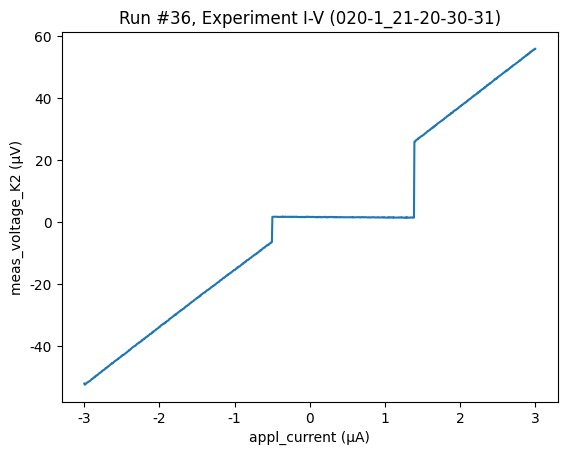

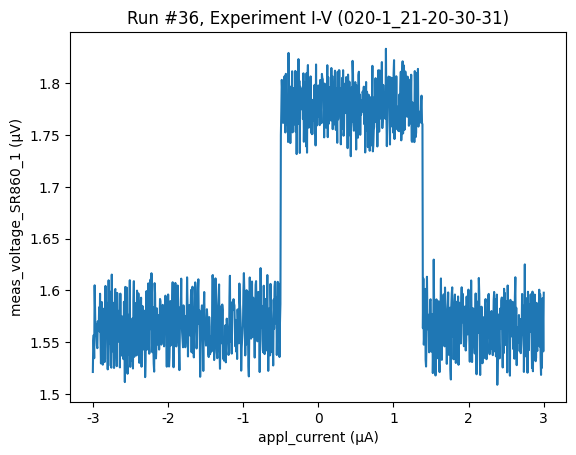

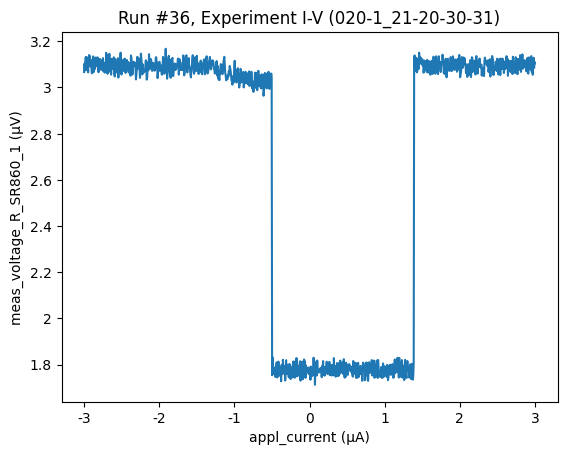

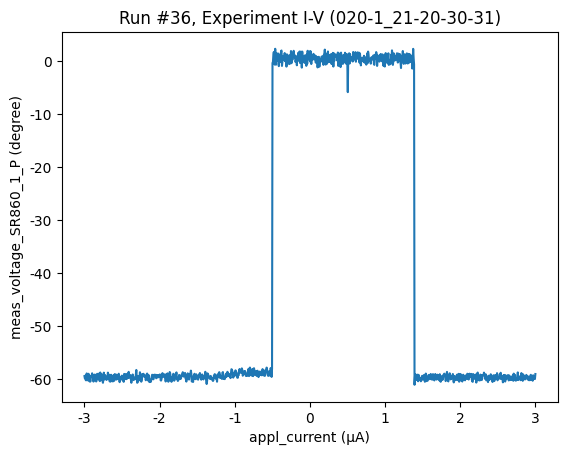

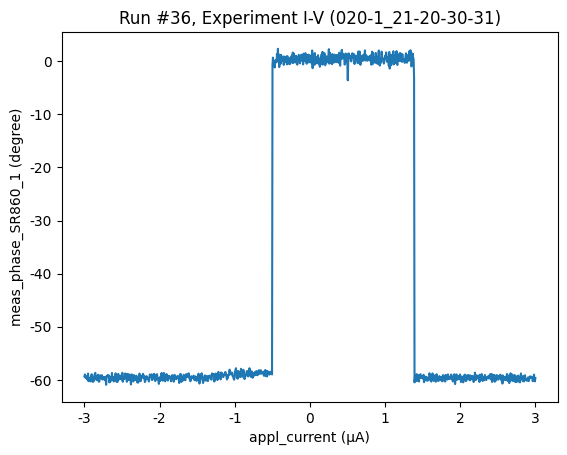

In [4]:
plot_by_id(36)

In [13]:
from scipy.signal import find_peaks
def find_peaks_and_plot(df, show_plot=True):
    current_0_index = df['appl_current'].abs().idxmin()

    # Find positive and negative peaks
    positive_peaks, _ = find_peaks(df['dV/dI'][df['appl_current'] > 0])
    negative_peaks, _ = find_peaks(df['dV/dI'][df['appl_current'] < 0])

    # Extract peak information
    positive_peak_current = [df['appl_current'].iloc[current_0_index + i+1] for i in positive_peaks]
    positive_peak_R = [df['dV/dI'].iloc[current_0_index + i+1] for i in positive_peaks]
    negative_peak_current = df['appl_current'].iloc[negative_peaks].values
    negative_peak_R = df['dV/dI'].iloc[negative_peaks].values

    # Find maximum peaks
    positive_peak_index = np.argmax(positive_peak_R)
    negative_peak_index = np.argmax(negative_peak_R)

    if show_plot:
        # Print peak information
        print("Positive peak:")
        print(f"  Current: {positive_peak_current[positive_peak_index]}")
        print(f"  dV/dI: {positive_peak_R[positive_peak_index]:.2f}")
        print("Negative peak:")
        print(f"  Current: {negative_peak_current[negative_peak_index]}")
        print(f"  dV/dI: {negative_peak_R[negative_peak_index]:.2f}")
        # Plot the data and peaks
        plt.plot(df['appl_current'], df['dV/dI'])
        plt.scatter(positive_peak_current, positive_peak_R, color='red', label='Positive Peak')
        plt.scatter(negative_peak_current, negative_peak_R, color='blue', label='Negative Peak')
        plt.legend()
        plt.show()
    else:
        return positive_peak_current[positive_peak_index], negative_peak_current[negative_peak_index]

def get_R_fit0(run_id):
    dataset = qc.load_by_id(run_id)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    peaks, _ = find_peaks(df['dV/dI'])
    # Extract peak current and peak differential voltage values
    peak_current = [df['appl_current'][i] for i in peaks]
    peak_R = [df['dV/dI'][i] for i in peaks]

    # Sort the peaks based on their values
    sorted_peak_indices = np.argsort(peak_R)[::-1]  # Sort in descending order
    top_two_peak_indices = sorted_peak_indices[:2]  # Select the top two indices

    # Extract the top two peaks
    top_two_peak_current = [peak_current[i] for i in top_two_peak_indices]
    top_two_peak_R = [peak_R[i] for i in top_two_peak_indices]
    # Ensure peak0 is less than paek1
    peak0, peak1 = top_two_peak_current
    if peak1 < peak0:
        peak0, peak1 = peak1, peak0
        top_two_peak_current = peak0, peak1
    df_0 = df[df['appl_current'] < peak0]
    df_1 = df[df['appl_current'] > peak1]

    fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'] , 1)
    fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'] , 1)
    R_fit0 = fit_0[0]
    R_fit1 = fit_1[0]
    R_fit = (R_fit0 + R_fit1) / 2
    current_0_index = df['appl_current'].abs().idxmin()
    Ic = top_two_peak_current[1]-df['appl_current'].iloc[current_0_index]
    IcRn = Ic*R_fit
    return R_fit, R_fit0 ,R_fit1, top_two_peak_current, Ic, IcRn, current_0_index

def get_R_fit(run_id):
    dataset = qc.load_by_id(run_id)
    df = dataset.to_pandas_dataframe().reset_index()
    para_list = dataset.parameters.split(",")
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(
        dataset)
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    Ic, Ir = find_peaks_and_plot(df, show_plot=False)
    df_0 = df[df['appl_current'] < Ir]
    df_1 = df[df['appl_current'] > Ic]
    fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'] , 1)
    fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'] , 1)
    R_fit0 = fit_0[0]
    R_fit1 = fit_1[0]
    R_fit = (R_fit0 + R_fit1) / 2
    current_0_index = df['appl_current'].abs().idxmin()
    IcRn = Ic*R_fit
    # Calculate the resistance between the peaks
    df_between_peaks = df[(df['appl_current'] > Ir) & (df['appl_current'] < Ic)]


    fit_between_peaks = np.polyfit(df_between_peaks['appl_current'], df_between_peaks['meas_voltage_K2'], 1)
    R_fit_between_peaks = fit_between_peaks[0]
    return R_fit, R_fit0 ,R_fit1, R_fit_between_peaks, Ic, Ir, IcRn, current_0_index, df


def plot_IV_and_dVdI(run_id=1):
    dataset = qc.load_by_id(run_id)
    run_id, exp_name, sample_name, sample_junction, name, description = get_detaset_info(dataset)
    df = dataset.to_pandas_dataframe().reset_index()
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    para_list = dataset.parameters.split(",")
    R_fit, R_fit0 ,R_fit1, R_fit_between_peaks, Ic, Ir, IcRn, current_0_index, df = get_R_fit(run_id)
    # Create traces
    # Trace1 IV
    trace1 = go.Scatter(x=df['appl_current'], y=df['meas_voltage_K2'], mode='lines', name='IV')
    # Trace2 dV/dI
    trace2 = go.Scatter(x=df['appl_current'], y=df['dV/dI'], mode='lines', name='dV/dI', yaxis='y2')
    trace3 = go.Scatter(x=[Ir, Ir], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak0',yaxis='y2')
    trace4 = go.Scatter(x=[Ic, Ic], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='Peak1',yaxis='y2')
    trace5 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], df['appl_current'].iloc[current_0_index]], y=[df['dV/dI'].min(), df['dV/dI'].max()], mode='lines', line=dict(dash='dash'), name='I_0',yaxis='y2')
    trace6 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], Ic], y=[0, 0], mode='lines', line=dict(dash='dash'), name='Ic')
    # Trace7 I_r
    trace7 = go.Scatter(x=[df['appl_current'].iloc[current_0_index], Ir], y=[0, 0], mode='lines', line=dict(dash='dash'), name='Ir')
    # Trace8 R_fit 
    trace8 = go.Scatter(x=[df['appl_current'].min(), df['appl_current'].max()], y=[R_fit*df['appl_current'].min(), R_fit*df['appl_current'].max()], mode='lines', line=dict(dash='dash'), name='R_fit') 
    
    # Create layout
    layout = go.Layout(
        title=f'<b>#{run_id} {exp_name} {sample_name}<br>R_fit={R_fit:.4f} Ω', 
        title_font=dict(size=25), title_x=0,
        xaxis=dict(title=para_list[0], tickfont=dict(size=16),title_font=dict(size=20)),
        yaxis=dict(title=f"{para_list[1]}", tickfont=dict(size=16),title_font=dict(size=20)),
        yaxis2=dict(title='dV/dI', tickfont=dict(size=16),title_font=dict(size=20), overlaying='y', side='right'),
        width=1000, height=1000, margin=dict(l=10, r=10, t=50, b=10),
        legend=dict(orientation="h",
                    x=0.5, y=1.03,
                    xanchor="center", yanchor="top",)
    )

    fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8], layout=layout)
    fig.update_layout(
        annotations=[
            go.layout.Annotation(
                x=1,
                y=1,
                xref="paper",
                yref="paper",
                text=f"Ic: {Ic*1e6:.3f}µA, Ir: {Ir*1e6:.3f}µA, IcRn: {IcRn*1e6:.3f}µV",
                showarrow=False,
                font=dict(
                    size=16,
                    color="#ffffff"
                ),
                align="right",
                bgcolor="#ff7f0e",
                opacity=0.8
            )
        ]
    )
    fig.show()
    print(f"Ic = {Ic*1e6} µA\n",
          f"Ir = {Ir*1e6} µA\n", 
          f"R_fit = {R_fit} Ω\n", 
          f"IcRn = {Ic*1e6*R_fit} µV\n",
          f"R_fit0 = {R_fit0} Ω\n", 
          f"R_fit1 = {R_fit1} Ω\n",
          f"R_fit_SC = {R_fit_between_peaks} Ω\n"
          f"Rn = {R_fit-R_fit_between_peaks} Ω\n"
          )
    return 

def get_R_fit_df(df):
    df = df.reset_index(drop=True)
    df['dV/dI'] = pd.DataFrame(np.diff(df['meas_voltage_K2']) / np.diff(df['appl_current']), columns=['r']).reindex(df.index, method=None)
    Ic, Ir = find_peaks_and_plot(df, show_plot=False)
    df_0 = df[df['appl_current'] < Ir]
    df_1 = df[df['appl_current'] > Ic]
    fit_0 = np.polyfit(df_0['appl_current'], df_0['meas_voltage_K2'] , 1)
    fit_1 = np.polyfit(df_1['appl_current'], df_1['meas_voltage_K2'] , 1)
    R_fit0 = fit_0[0]
    R_fit1 = fit_1[0]
    R_fit = (R_fit0 + R_fit1) / 2
    I0_idx = df['appl_current'].abs().idxmin()
    IcRn = Ic*R_fit
    # Calculate the resistance between the peaks
    df_between_peaks = df[(df['appl_current'] > Ir) & (df['appl_current'] < Ic)]


    fit_between_peaks = np.polyfit(df_between_peaks['appl_current'], df_between_peaks['meas_voltage_K2'], 1)
    R_fit_between_peaks = fit_between_peaks[0]

    return pd.Series({
        'R_fit': R_fit,
        'R_fit0': R_fit0,
        'R_fit1': R_fit1,
        'R_fit_SC': R_fit_between_peaks,
        'Ic': Ic,
        'Ir': Ir,
        'IcRn': IcRn,
    })

def merge_df(df):
    # 對 y_field 進行分組並應用計算函數
    results = df.groupby('y_field').apply(get_R_fit_df, include_groups=False).reset_index()

    # 將結果與原始數據合併
    df_merged = df.merge(results, on='y_field', how='left')
    return df_merged

def infer_shape_from_repeated_values(arr):
    # 初始化变量
    row_length = 0
    current_value = None
    current_count = 0
    
    # 遍历数组，寻找连续相同值的数量
    for value in arr:
        if value == current_value:
            current_count += 1
        else:
            if current_count > 0:
                if row_length == 0:
                    row_length = current_count
                elif row_length != current_count:
                    raise ValueError("数组中连续相同值的数量不一致，无法确定形状")
            current_value = value
            current_count = 1
    
    # 最后一个值的处理
    if current_count > 0:
        if row_length == 0:
            row_length = current_count
        elif row_length != current_count:
            raise ValueError("数组中连续相同值的数量不一致，无法确定形状")

    # 计算行数
    num_rows = len(arr) // row_length
    
    if len(arr) % row_length != 0:
        raise ValueError("数组长度无法整除推断出的行长度，无法确定形状")

    # 返回推断的形状
    return (num_rows, row_length)

def get_detaset_info(dataset):
    run_id = dataset.captured_run_id
    exp_name = dataset.exp_name
    sample_name = dataset.sample_name
    name = dataset.name
    description = dataset.description
    sample_junction = extract_sample_junction(sample_name)
    return run_id, exp_name, sample_name, sample_junction, name, description

def extract_sample_junction(sample_name):
    """Extracts the complete sample junction from the provided sample name.

    Args:
      sample_name: The name of the sample containing the junction information.

    Returns:
      The extracted sample junction, or None if not found.
    """

    delimiter = "_J"
    if delimiter in sample_name:
        # +3 to include "_J"
        return sample_name[:sample_name.find(delimiter) + 3]
    else:
        return None

In [14]:
plot_IV_and_dVdI(36)

Ic = 1.386 µA
 Ir = -0.504 µA
 R_fit = 18.61631187564084 Ω
 IcRn = 25.802208259638203 µV
 R_fit0 = 18.52435648065422 Ω
 R_fit1 = 18.708267270627456 Ω
 R_fit_SC = -0.1437003891619929 Ω
Rn = 18.760012264802832 Ω



In [5]:
dataset = qc.load_by_id(36)

def _display_time(run_time):
    total_seconds = int(run_time.total_seconds())

    if total_seconds < 60:
        display_time = f"{total_seconds} sec"
    elif total_seconds < 3600:
        minutes, seconds = divmod(total_seconds, 60)
        display_time = f"{minutes} min {seconds} sec" if seconds else f"{minutes} min"
    else:
        hours, remainder = divmod(total_seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        display_time = f"{hours} hr {minutes} min" if minutes else f"{hours} hr"
    return display_time 

# 獲取數據集信息
run_id, exp_name, sample_name, description, start_time, completed_time, run_time, display_time = get_dataset_info(dataset)

# Get parameters and auto-detect voltmeter
parameters = dataset.get_parameters()
voltage_param = next((p for p in parameters if p.name.startswith('meas_voltage')), None)

if voltage_param is None:
    raise ValueError("No voltage measurement parameter found")

voltmeter = voltage_param.name.split('_')[-1]  # e.g., 'K1' or 'K2'
voltage_unit = voltage_param.unit

# Extract data from the dataset
data = dataset.get_parameter_data()
appl_current = data[voltage_param.name]['appl_current']
meas_voltage = data[voltage_param.name][voltage_param.name]
meas_voltage_avg = np.mean(meas_voltage)



# Calculate dV/dI
dV = np.diff(meas_voltage)
dI = np.diff(appl_current)
dVdI = dV / dI

# Apply Savitzky-Golay filter to smooth dV/dI
dVdI_smooth = savgol_filter(dVdI, window_length=6, polyorder=3)
# dVdI_smooth = dVdI 
# Auto-select appropriate units for dV/dI
dVdI_avg, dVdI_unit = auto_select_unit(np.mean(dVdI), 'Ω')


# Find peaks for positive and negative current regions
positive_current_mask = appl_current[1:] > 0
negative_current_mask = appl_current[1:] < 0

# Find peaks in positive current region
positive_peaks, _ = find_peaks(dVdI_smooth[positive_current_mask], height=np.mean(dVdI_smooth[positive_current_mask]))
if len(positive_peaks) > 0:
    positive_peak_index = positive_peaks[0]  # Take the first peak
    positive_peak_current = appl_current[1:][positive_current_mask][positive_peak_index]
    positive_peak_dvdi = dVdI_smooth[positive_current_mask][positive_peak_index]

# Find peaks in negative current region
negative_peaks, _ = find_peaks(dVdI_smooth[negative_current_mask], height=np.mean(dVdI_smooth[negative_current_mask]))
if len(negative_peaks) > 0:
    negative_peak_index = negative_peaks[0]  # Take the first peak
    negative_peak_current = appl_current[1:][negative_current_mask][negative_peak_index]
    negative_peak_dvdi = dVdI_smooth[negative_current_mask][negative_peak_index]

# Get current unit
current_param = next(p for p in parameters if p.name == 'appl_current')
current_unit = current_param.unit

# Calculate the step size and number of points
current_step = (appl_current[len(appl_current)-1]-appl_current[0])/(len(appl_current)-1)
current_points = len(appl_current)

# Auto-select appropriate units for step sizes
auto_current_step, auto_current_unit = auto_select_unit(current_step, current_unit)

# Create hover text
hover_text = [f'{voltmeter}<br>Current: {i:.2e} {current_unit}<br>Voltage: {v:.2e} {voltage_unit}' for i, v in zip(appl_current, meas_voltage)]
# Create the scatter plot
fig = go.Figure(data=go.Scatter(
    x=appl_current,
    y=meas_voltage,
    mode='markers',
    name='IV Curve',
    hovertext=hover_text,
    hoverinfo='text'
))

fig.add_trace(go.Scatter(
    x=appl_current[1:],
    y=dVdI_smooth,
    mode='lines',
    name='dV/dI (smoothed)',
    yaxis='y2',
    hovertext=hover_text,
    hoverinfo='text'
))

fig.add_trace(go.Scatter(
    x=appl_current[1:],
    y=dVdI,
    mode='lines',
    name='dV/dI',
    yaxis='y2',
    hovertext=hover_text,
    hoverinfo='text'
))

fig.add_trace(go.Scatter(
    x=appl_current,
    y=np.array([meas_voltage_avg]),
    mode='lines',
    name='Average Voltage',
    yaxis='y1',
    # hovertext=hover_text,
    # hoverinfo='text'
))


# Add peak markers
if 'positive_peak_current' in locals():
    fig.add_trace(go.Scatter(
        x=[positive_peak_current],
        y=[positive_peak_dvdi],
        mode='markers',
        name='Positive Current Peak',
        marker=dict(size=10, color='red', symbol='star'),
        yaxis='y2'
    ))

if 'negative_peak_current' in locals():
    fig.add_trace(go.Scatter(
        x=[negative_peak_current],
        y=[negative_peak_dvdi],
        mode='markers',
        name='Negative Current Peak',
        marker=dict(size=10, color='blue', symbol='star'),
        yaxis='y2'
    ))

# Update layout
fig.update_layout(
    title=f'<b>#{run_id}|{exp_name}|</b> {sample_name}',
    xaxis_title=f'Applied Current ({current_unit})',
    yaxis_title=f'Measured Voltage ({voltage_unit})',
    yaxis2=dict(
        title=f'dV/dI (Ω)',
        overlaying='y',
        side='right'
    ),
    legend=dict(orientation="h",
                    x=0.5, y=1,
                    xanchor="center", yanchor="bottom",),
    font=dict(size=14),
    width=800, height=800
)
# Add description as annotation
fig.add_annotation(
    xref='paper', yref='paper',
    x=0.01, y=0.99,
    text=f'{start_time}<br>{current_points} pt, {display_time}',
    showarrow=False,
    font=dict(size=12),
    align='left',
)

fig.add_annotation(
    xref='paper', yref='paper',
    x=0.99, y=0.01,
    text=f'Step size: {auto_current_step:.1f} {auto_current_unit}',
    showarrow=False,
    font=dict(size=12),
    align='right',
)

# Show the plot
fig.show()

In [215]:
dataset = qc.load_by_id(66)

def _display_time(run_time):
    total_seconds = int(run_time.total_seconds())

    if total_seconds < 60:
        display_time = f"{total_seconds} sec"
    elif total_seconds < 3600:
        minutes, seconds = divmod(total_seconds, 60)
        display_time = f"{minutes} min {seconds} sec" if seconds else f"{minutes} min"
    else:
        hours, remainder = divmod(total_seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        display_time = f"{hours} hr {minutes} min" if minutes else f"{hours} hr"
    return display_time 

# 獲取數據集信息
run_id, exp_name, sample_name, description, start_time, completed_time, run_time, display_time = get_dataset_info(dataset)

# Get parameters and auto-detect voltmeter
parameters = dataset.get_parameters()
voltage_param = next((p for p in parameters if p.name.startswith('meas_voltage')), None)

if voltage_param is None:
    raise ValueError("No voltage measurement parameter found")

voltmeter = voltage_param.name.split('_')[-1]  # e.g., 'K1' or 'K2'
voltage_unit = voltage_param.unit

# Extract data from the dataset
data = dataset.get_parameter_data()
appl_current = data[voltage_param.name]['appl_current']
meas_voltage = data[voltage_param.name][voltage_param.name]
meas_voltage_avg = np.mean(meas_voltage)

# Calculate dV/dI
dV = np.diff(meas_voltage)
dI = np.diff(appl_current)
dVdI = dV / dI


# 計算 meas_voltage 的平均值和標準差
meas_voltage_mean = np.mean(meas_voltage)
meas_voltage_std = np.std(meas_voltage)

# 計算 +-0.8 個標準差的範圍
lower_bound = meas_voltage_mean - 0.8 * meas_voltage_std
upper_bound = meas_voltage_mean + 0.8 * meas_voltage_std

# 過濾出在這個範圍內的 appl_current 和 meas_voltage 數據
filtered_indices = (meas_voltage >= lower_bound) & (meas_voltage <= upper_bound)
filtered_appl_current = appl_current[filtered_indices]
filtered_meas_voltage = meas_voltage[filtered_indices]

# 計算過濾後的 dV/dI
filtered_dVdI = np.diff(filtered_meas_voltage) / np.diff(filtered_appl_current)

# 計算Savitzky-Golay平滑過濾後的 dV/dI
filtered_dVdI_smooth = savgol_filter(filtered_dVdI, window_length=6, polyorder=3)

# 對平滑過濾後的 dV/dI 數據進行峰值檢測
filtered_dVdI_smooth_peaks, properties = find_peaks(filtered_dVdI_smooth, height=np.mean(filtered_dVdI_smooth))

# 如果找到峰值，提取數值最大的兩個峰值
if len(filtered_dVdI_smooth_peaks) > 0:
    peak_heights = properties['peak_heights']
    top_two_peaks_indices = np.argsort(peak_heights)[-2:]  # 取數值最大的兩個峰值索引
    smooth_peak_indices = filtered_dVdI_smooth_peaks[top_two_peaks_indices]
    smooth_peak_currents = filtered_appl_current[1:][smooth_peak_indices]
    smooth_peak_dvdi = filtered_dVdI_smooth[smooth_peak_indices]

    # 分辨出 >0 和 <0 的峰值
    positive_peak_index = smooth_peak_indices[smooth_peak_currents > 0][0]
    negative_peak_index = smooth_peak_indices[smooth_peak_currents < 0][0]

    positive_peak_current = smooth_peak_currents[smooth_peak_currents > 0][0]
    negative_peak_current = smooth_peak_currents[smooth_peak_currents < 0][0]

    positive_peak_dvdi = smooth_peak_dvdi[smooth_peak_currents > 0][0]
    negative_peak_dvdi = smooth_peak_dvdi[smooth_peak_currents < 0][0]

# Ic = positive_peak_current 
# Ir = negative_peak_current 
Ic = appl_current[int(np.where(appl_current == positive_peak_current)[0][0])]
Ir = appl_current[int(np.where(appl_current == negative_peak_current)[0][0])]


# # Apply Savitzky-Golay filter to smooth dV/dI
dVdI_smooth = savgol_filter(dVdI, window_length=6, polyorder=3)
# # dVdI_smooth = dVdI 
# Auto-select appropriate units for dV/dI
dVdI_avg, dVdI_unit = auto_select_unit(np.mean(dVdI), 'Ω')

# # Find peaks for positive and negative current regions
# positive_current_mask = appl_current[1:] > 0
# negative_current_mask = appl_current[1:] < 0

# # Find peaks in positive current region
# positive_peaks, _ = find_peaks(dVdI_smooth[positive_current_mask], height=np.mean(dVdI_smooth[positive_current_mask]))
# if len(positive_peaks) > 0:
#     positive_peak_index = positive_peaks[0]  # Take the first peak
#     positive_peak_current = appl_current[1:][positive_current_mask][positive_peak_index]
#     positive_peak_dvdi = dVdI_smooth[positive_current_mask][positive_peak_index]

# # Find peaks in negative current region
# negative_peaks, _ = find_peaks(dVdI_smooth[negative_current_mask], height=np.mean(dVdI_smooth[negative_current_mask]))
# if len(negative_peaks) > 0:
#     negative_peak_index = negative_peaks[0]  # Take the first peak
#     negative_peak_current = appl_current[1:][negative_current_mask][negative_peak_index]
#     negative_peak_dvdi = dVdI_smooth[negative_current_mask][negative_peak_index]

# Get current unit
current_param = next(p for p in parameters if p.name == 'appl_current')
current_unit = current_param.unit

# Calculate the step size and number of points
current_step = (appl_current[len(appl_current)-1]-appl_current[0])/(len(appl_current)-1)
current_points = len(appl_current)

# Auto-select appropriate units for step sizes
auto_current_step, auto_current_unit = auto_select_unit(current_step, current_unit)

# Create hover text
hover_text = [f'{voltmeter}<br>Current: {i:.2e} {current_unit}<br>Voltage: {v:.2e} {voltage_unit}' for i, v in zip(appl_current, meas_voltage)]

# Calculate average IV curve
avg_current = np.mean(appl_current)
avg_voltage = np.mean(meas_voltage)


data = meas_voltage

# 計算標準差
std_dev = np.std(data)

# 定義你想要的標準差倍數
std_multiples = [0, 0.1, 0.2, 0.5]

# 計算標準差倍數對應的值
std_values = [meas_voltage_avg + multiple * std_dev for multiple in std_multiples] + [meas_voltage_avg - multiple * std_dev for multiple in std_multiples]

# # 定義你想要的分位數
# percentiles = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# # 計算分位數
# quantiles = np.percentile(data, percentiles)

# Create the traces
# IV 
trace1 = go.Scatter(
    x=appl_current,
    y=meas_voltage,
    mode='markers',
    name='IV',
    hovertext=hover_text,
    hoverinfo='text'
)

trace2 = go.Scatter(
    x=appl_current,
    y=dVdI_smooth,
    mode='lines',
    name='dV/dI (smoothed)',
    yaxis='y2',
    hovertext=hover_text,
    hoverinfo='text'
)

trace3 = go.Scatter(
    x=appl_current,
    y=dVdI,
    mode='lines',
    name='dV/dI',
    yaxis='y2',
    hovertext=hover_text,
    hoverinfo='text'
)

# 繪製平滑過濾後的峰值
trace4 = go.Scatter(
    x=[positive_peak_current],
    y=[positive_peak_dvdi],
    mode='markers',
    name='Positive Peak',
    marker=dict(size=10, color='red', symbol='star'),
    yaxis='y2'
)

trace5 = go.Scatter(
    x=[negative_peak_current],
    y=[negative_peak_dvdi],
    mode='markers',
    name='Negative Peak',
    marker=dict(size=10, color='green', symbol='star'),
    yaxis='y2'
)

trace6 = go.Scatter(x=[Ir, Ir], y=[min(dVdI), max(dVdI)], mode='lines', line=dict(dash='dash'), name='Peak0',yaxis='y2')
trace7 = go.Scatter(x=[Ic, Ic], y=[min(dVdI), max(dVdI)], mode='lines', line=dict(dash='dash'), name='Peak1',yaxis='y2')

#trace for filtered_dVdI_smooth
trace8 = go.Scatter(
    x=filtered_appl_current[1:],
    y=filtered_dVdI_smooth,
    mode='lines',
    name='filtered_dV/dI (smoothed)',
    yaxis='y2',
)    
    

# trace4 = go.Scatter(
#     x=appl_current,
#     y=np.array([meas_voltage_avg]),
#     mode='lines',
#     name='Average Voltage',
#     yaxis='y1',
#     # hovertext=hover_text,
#     # hoverinfo='text'
# )

# trace5 = go.Scatter(
#     x=[positive_peak_current] if 'positive_peak_current' in locals() else [],
#     y=[positive_peak_dvdi] if 'positive_peak_dvdi' in locals() else [],
#     mode='markers',
#     name='Positive Current Peak',
#     marker=dict(size=10, color='red', symbol='star'),
#     yaxis='y2'
# )

# trace6 = go.Scatter(
#     x=[negative_peak_current] if 'negative_peak_current' in locals() else [],
#     y=[negative_peak_dvdi] if 'negative_peak_dvdi' in locals() else [],
#     mode='markers',
#     name='Negative Current Peak',
#     marker=dict(size=10, color='blue', symbol='star'),
#     yaxis='y2'
# )

# Add average IV curve trace
# trace7 = go.Scatter(
#     x=appl_current,
#     y=[avg_voltage] * len(appl_current),  # Create a list of avg_voltage with the same length as appl_current
#     mode='lines',  # Change mode to 'lines' to draw a line
#     name='Average IV',
#     marker=dict(size=10, color='green', symbol='diamond'),
#     hovertext=f'Average Current: {avg_current:.2e} {current_unit}<br>Average Voltage: {avg_voltage:.2e} {voltage_unit}',
#     hoverinfo='text'
# )

# Update layout
layout = go.Layout(
    title=f'<b>#{run_id}|{exp_name}|</b> {sample_name}',
    xaxis_title=f'Applied Current ({current_unit})',
    yaxis_title=f'Measured Voltage ({voltage_unit})',
    yaxis2=dict(
        title=f'dV/dI (Ω)',
        overlaying='y',
        side='right'
    ),
    legend=dict(orientation="h",
                x=0.5, y=1,
                xanchor="center", yanchor="bottom",),
    font=dict(size=14),
    width=1200, height=1000
)

# Create the figure
fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8], layout=layout)

# Add description as annotation
fig.add_annotation(
    xref='paper', yref='paper',
    x=0.01, y=0.99,
    text=f'{start_time}<br>{current_points} pt, {display_time}',
    showarrow=False,
    font=dict(size=12),
    align='left',
)

fig.add_annotation(
    xref='paper', yref='paper',
    x=0.99, y=0.01,
    text=f'Step size: {auto_current_step:.1f} {auto_current_unit}',
    showarrow=False,
    font=dict(size=12),
    align='right',
)

# # 添加分位數作為水平線
# for p, q in zip(percentiles, quantiles):
#     fig.add_shape(
#         type="line",
#         x0=min(appl_current), y0=q, x1=max(appl_current), y1=q,
#         line=dict(color="Red", width=2, dash="dash"),
#         xref='x', yref='y'
#     )
#     fig.add_annotation(
#         x=max(appl_current), y=q,
#         text=f'{p}th',
#         showarrow=True,
#         arrowhead=2,
#         ax=40,
#         ay=0
#     )

# 添加標準差倍數作為水平線
for multiple, value in zip(std_multiples + [-m for m in std_multiples], std_values):
    fig.add_shape(
        type="line",
        x0=min(appl_current),
        y0=value,
        x1=max(appl_current),
        y1=value,
        line=dict(color="Gray", width=0.5, dash="dash"),
        xref='x',
        yref='y'
    )
    fig.add_annotation(
        xref='paper',
        x=0.01,
        y=value,
        text=f'{multiple}σ',
        showarrow=True,
        arrowhead=1,
        ax=-40,
        ay=0
    )


# Show the plot
fig.show()

In [190]:
filtered_dVdI_smooth_peaks

array([ 1,  6,  9, 11, 16, 18, 22, 24, 29, 31, 38, 44, 50])

In [141]:
smooth_peak_currents[positive_peak_index]

IndexError: index 27 is out of bounds for axis 0 with size 2

In [166]:
# 找出等於 positive_peak_current 的索引
indices = np.where(appl_current == positive_peak_current)[0]

print(indices)

[54]


In [175]:
int(np.where(appl_current == positive_peak_current)[0][0])-1

53

In [167]:
appl_current[indices]

array([8.e-08])

In [177]:
Ic = appl_current[int(np.where(appl_current == positive_peak_current)[0][0])-1]
Ir = appl_current[int(np.where(appl_current == negative_peak_current)[0][0])+1]

In [165]:
Ic

'[6.00000000000001e-08]'

In [153]:
Ic = appl_current[np.where(appl_current == positive_peak_current)[0]-1]
Ir = appl_current[np.where(appl_current == negative_peak_current)[0]+1]


6.00000000000001e-08

In [147]:
smooth_peak_currents

array([ 8.e-08, -8.e-08])

In [148]:
positive_peak_current

8.00000000000001e-08

In [120]:

positive_peak_index = smooth_peak_indices[smooth_peak_currents > 0][0]-1
negative_peak_index = smooth_peak_indices[smooth_peak_currents < 0][0]+1

positive_peak_current = smooth_peak_currents[smooth_peak_currents > 0][0]-1
negative_peak_current = smooth_peak_currents[smooth_peak_currents < 0][0]+1

positive_peak_dvdi = smooth_peak_dvdi[smooth_peak_currents > 0][0]-1
negative_peak_dvdi = smooth_peak_dvdi[smooth_peak_currents < 0][0]+1

print(
    positive_peak_index,
    negative_peak_index,
    positive_peak_current,
    negative_peak_current, 
    positive_peak_dvdi,
    negative_peak_dvdi
    )

37 10 -0.99999944 0.9999994 5.62296476562499 6.663937812499994


In [118]:
negative_peak_index

9

In [128]:
import numpy as np
from scipy.signal import find_peaks
import plotly.graph_objects as go

# 假設 meas_voltage 和 appl_current 已經定義
# 計算 meas_voltage 的平均值和標準差
meas_voltage_mean = np.mean(meas_voltage)
meas_voltage_std = np.std(meas_voltage)

# 計算 +-0.5 個標準差的範圍
lower_bound = meas_voltage_mean - 0.7 * meas_voltage_std
upper_bound = meas_voltage_mean + 0.7 * meas_voltage_std

# 過濾出在這個範圍內的 appl_current 和 meas_voltage 數據
filtered_indices = (meas_voltage >= lower_bound) & (meas_voltage <= upper_bound)
filtered_appl_current = appl_current[filtered_indices]
filtered_meas_voltage = meas_voltage[filtered_indices]

# 計算過濾後的 dV/dI
filtered_dVdI = np.diff(filtered_meas_voltage) / np.diff(filtered_appl_current)

# 對過濾後的 dV/dI 數據進行峰值檢測
filtered_peaks, _ = find_peaks(filtered_dVdI, height=np.mean(filtered_dVdI))

# 計算Savitzky-Golay平滑過濾後的 dV/dI
filtered_dVdI_smooth = savgol_filter(filtered_dVdI, window_length=6, polyorder=3)

# 對平滑過濾後的 dV/dI 數據進行峰值檢測
filtered_dVdI_smooth_peaks, _ = find_peaks(filtered_dVdI_smooth, height=np.mean(filtered_dVdI_smooth))

# 如果找到峰值，提取峰值信息
if len(filtered_peaks) > 0:
    filtered_peak_indices = filtered_peaks
    filtered_peak_currents = filtered_appl_current[1:][filtered_peak_indices]
    filtered_peak_dvdi = filtered_dVdI[filtered_peak_indices]

# 繪製過濾後的峰值
trace_filtered_peaks = go.Scatter(
    x=filtered_peak_currents,
    y=filtered_peak_dvdi,
    mode='markers',
    name='Filtered Peaks',
    marker=dict(size=10, color='purple', symbol='star'),
    yaxis='y2'
)

# 更新圖表
fig.add_trace(trace_filtered_peaks)

# 顯示圖表

In [88]:
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import plotly.graph_objects as go

# 假設 meas_voltage 和 appl_current 已經定義
# 計算 meas_voltage 的平均值和標準差
meas_voltage_mean = np.mean(meas_voltage)
meas_voltage_std = np.std(meas_voltage)

# 計算 +-0.5 個標準差的範圍
lower_bound = meas_voltage_mean - 0.8 * meas_voltage_std
upper_bound = meas_voltage_mean + 0.8 * meas_voltage_std

# 過濾出在這個範圍內的 appl_current 和 meas_voltage 數據
filtered_indices = (meas_voltage >= lower_bound) & (meas_voltage <= upper_bound)
filtered_appl_current = appl_current[filtered_indices]
filtered_meas_voltage = meas_voltage[filtered_indices]

# 計算過濾後的 dV/dI
filtered_dVdI = np.diff(filtered_meas_voltage) / np.diff(filtered_appl_current)

# 對過濾後的 dV/dI 數據進行峰值檢測
filtered_peaks, _ = find_peaks(filtered_dVdI, height=np.mean(filtered_dVdI))

# 計算Savitzky-Golay平滑過濾後的 dV/dI
filtered_dVdI_smooth = savgol_filter(filtered_dVdI, window_length=6, polyorder=3)

# # 對平滑過濾後的 dV/dI 數據進行峰值檢測
# filtered_dVdI_smooth_peaks, _ = find_peaks(filtered_dVdI_smooth, height=np.mean(filtered_dVdI_smooth))

# # 如果找到峰值，提取峰值信息
# if len(filtered_dVdI_smooth_peaks) > 0:
# 	smooth_peak_indices = filtered_dVdI_smooth_peaks[:2]
# 	smooth_peak_currents = filtered_appl_current[1:][smooth_peak_indices]
# 	smooth_peak_dvdi = filtered_dVdI_smooth[smooth_peak_indices]
 
filtered_dVdI_smooth_peaks, properties = find_peaks(filtered_dVdI_smooth, height=np.mean(filtered_dVdI_smooth))
if len(filtered_dVdI_smooth_peaks) > 0:
    peak_heights = properties['peak_heights']
    top_two_peaks_indices = np.argsort(peak_heights)[-2:]  # 取數值最大的兩個峰值索引
    smooth_peak_indices = filtered_dVdI_smooth_peaks[top_two_peaks_indices]
    smooth_peak_currents = filtered_appl_current[1:][smooth_peak_indices]
    smooth_peak_dvdi = filtered_dVdI_smooth[smooth_peak_indices]

# 繪製平滑過濾後的峰值
trace_smooth_peaks = go.Scatter(
	x=smooth_peak_currents,
	y=smooth_peak_dvdi,
	mode='markers',
	name='Smooth Peaks',
	marker=dict(size=10, color='red', symbol='star'),
	yaxis='y2'
)

# 繪製平滑過濾後的 dV/dI 數據
trace_smooth_dVdI = go.Scatter(
	x=filtered_appl_current[1:],
	y=filtered_dVdI_smooth,
	mode='lines',
	name='Smooth dV/dI',
	line=dict(color='blue')
)

# 初始化圖表
# fig = go.Figure()

# 添加平滑過濾後的 dV/dI 數據和峰值
fig.add_trace(trace_smooth_dVdI)
fig.add_trace(trace_smooth_peaks)

# 顯示圖表
fig.show()

In [92]:
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import plotly.graph_objects as go

# 假設 meas_voltage 和 appl_current 已經定義
# 計算 meas_voltage 的平均值和標準差
meas_voltage_mean = np.mean(meas_voltage)
meas_voltage_std = np.std(meas_voltage)

# 計算 +-0.5 個標準差的範圍
lower_bound = meas_voltage_mean - 0.8 * meas_voltage_std
upper_bound = meas_voltage_mean + 0.8 * meas_voltage_std

# 過濾出在這個範圍內的 appl_current 和 meas_voltage 數據
filtered_indices = (meas_voltage >= lower_bound) & (meas_voltage <= upper_bound)
filtered_appl_current = appl_current[filtered_indices]
filtered_meas_voltage = meas_voltage[filtered_indices]

# 計算過濾後的 dV/dI
filtered_dVdI = np.diff(filtered_meas_voltage) / np.diff(filtered_appl_current)

# 計算Savitzky-Golay平滑過濾後的 dV/dI
filtered_dVdI_smooth = savgol_filter(filtered_dVdI, window_length=6, polyorder=3)

# 對平滑過濾後的 dV/dI 數據進行峰值檢測
filtered_dVdI_smooth_peaks, properties = find_peaks(filtered_dVdI_smooth, height=np.mean(filtered_dVdI_smooth))

# 如果找到峰值，提取數值最大的兩個峰值
if len(filtered_dVdI_smooth_peaks) > 0:
    peak_heights = properties['peak_heights']
    top_two_peaks_indices = np.argsort(peak_heights)[-2:]  # 取數值最大的兩個峰值索引
    smooth_peak_indices = filtered_dVdI_smooth_peaks[top_two_peaks_indices]
    smooth_peak_currents = filtered_appl_current[1:][smooth_peak_indices]
    smooth_peak_dvdi = filtered_dVdI_smooth[smooth_peak_indices]

    # 分辨出 >0 和 <0 的峰值
    positive_peak_index = smooth_peak_indices[smooth_peak_currents > 0][0]
    negative_peak_index = smooth_peak_indices[smooth_peak_currents < 0][0]

    positive_peak_current = smooth_peak_currents[smooth_peak_currents > 0][0]
    negative_peak_current = smooth_peak_currents[smooth_peak_currents < 0][0]

    positive_peak_dvdi = smooth_peak_dvdi[smooth_peak_currents > 0][0]
    negative_peak_dvdi = smooth_peak_dvdi[smooth_peak_currents < 0][0]

# 繪製平滑過濾後的峰值
trace_positive_peak = go.Scatter(
    x=[positive_peak_current],
    y=[positive_peak_dvdi],
    mode='markers',
    name='Positive Peak',
    marker=dict(size=10, color='red', symbol='star'),
    yaxis='y2'
)

trace_negative_peak = go.Scatter(
    x=[negative_peak_current],
    y=[negative_peak_dvdi],
    mode='markers',
    name='Negative Peak',
    marker=dict(size=10, color='green', symbol='star'),
    yaxis='y2'
)

# # 繪製平滑過濾後的 dV/dI 數據
# trace_smooth_dVdI = go.Scatter(
#     x=filtered_appl_current[1:],
#     y=filtered_dVdI_smooth,
#     mode='lines',
#     name='Smooth dV/dI',
#     line=dict(color='blue')
# )

# # 初始化圖表
# fig = go.Figure()

# 添加平滑過濾後的 dV/dI 數據和峰值
fig.add_trace(trace_smooth_dVdI)
fig.add_trace(trace_positive_peak)
fig.add_trace(trace_negative_peak)

# 顯示圖表
fig.show()

Mean Voltage: 2.77
Median Voltage: 0.30
Standard Deviation: 14.71
Min Voltage: -36.87
Max Voltage: 38.28
25th Percentile: -4.09
50th Percentile: 0.30
75th Percentile: 4.79


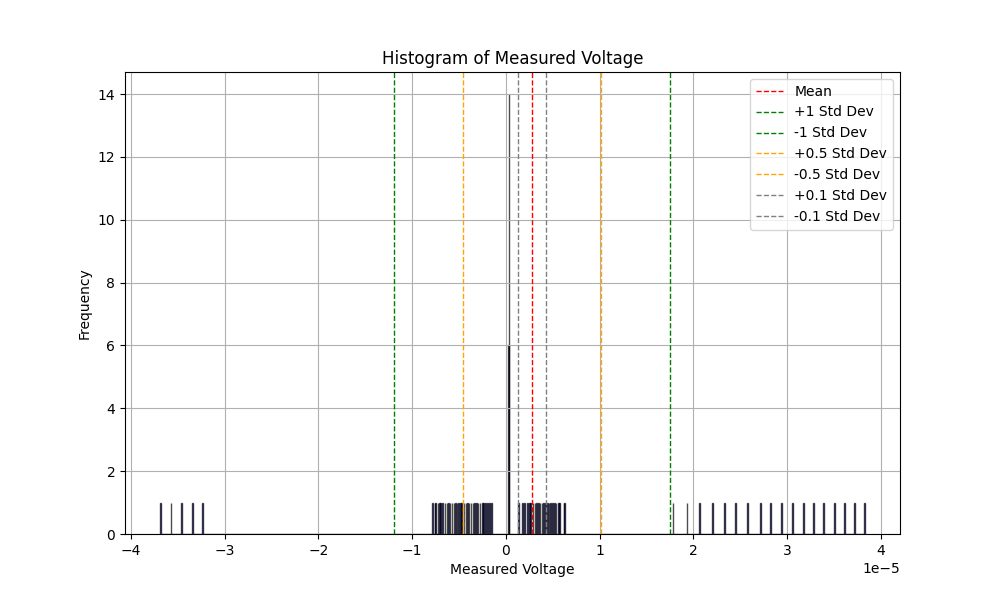

In [211]:

mean_voltage = np.mean(meas_voltage)
median_voltage = np.median(meas_voltage)
std_voltage = np.std(meas_voltage)
min_voltage = np.min(meas_voltage)
max_voltage = np.max(meas_voltage)
quantiles = np.percentile(meas_voltage, [25, 50, 75])

# 打印統計量
print(f"Mean Voltage: {mean_voltage*1e6:.2f}")
print(f"Median Voltage: {median_voltage*1e6:.2f}")
print(f"Standard Deviation: {std_voltage*1e6:.2f}")
print(f"Min Voltage: {min_voltage*1e6:.2f}")
print(f"Max Voltage: {max_voltage*1e6:.2f}")
print(f"25th Percentile: {quantiles[0]*1e6:.2f}")
print(f"50th Percentile: {quantiles[1]*1e6:.2f}")
print(f"75th Percentile: {quantiles[2]*1e6:.2f}")

# 繪製直方圖
plt.figure(figsize=(10, 6))
plt.hist(meas_voltage, bins=1001, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Measured Voltage')
plt.ylabel('Frequency')
plt.title('Histogram of Measured Voltage')
plt.grid(True)

# 標註一個和兩個標準差的位置
plt.axvline(mean_voltage, color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(mean_voltage + std_voltage, color='green', linestyle='dashed', linewidth=1, label='+1 Std Dev')
plt.axvline(mean_voltage - std_voltage, color='green', linestyle='dashed', linewidth=1, label='-1 Std Dev')
plt.axvline(mean_voltage + 0.5 * std_voltage, color='orange', linestyle='dashed', linewidth=1, label='+0.5 Std Dev')
plt.axvline(mean_voltage - 0.5 * std_voltage, color='orange', linestyle='dashed', linewidth=1, label='-0.5 Std Dev')
plt.axvline(mean_voltage + 0.1 * std_voltage, color='gray', linestyle='dashed', linewidth=1, label='+0.1 Std Dev')
plt.axvline(mean_voltage - 0.1 * std_voltage, color='gray', linestyle='dashed', linewidth=1, label='-0.1 Std Dev')

# 添加圖例
plt.legend()

plt.show()

In [210]:
%matplotlib ipympl

In [ ]:
meas_voltage_avg = np.mean(meas_voltage)
meas_voltage_avg

In [ ]:
print(f"{meas_voltage_avg:.2f} {voltage_unit} is the average voltage.")

In [ ]:
from Analysis_functions import *

In [ ]:
plot_IV_and_dVdI(run_id=15)